In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
# from node2vec import Node2Vec

df0 = pd.read_csv('Kenntnisse und Einstellungen im Finanzbereich.csv')
df0.drop(columns='Timestamp',inplace=True)
df1 = pd.read_csv('Attitudes and Knowledge Regarding Finance.csv')
df1.drop(columns='Timestamp',inplace=True)

In [64]:
mapper = list(['age','gender','nationality','education','employment','income','invested','inv_pref','att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7'])
df0.columns = mapper
df1.columns = mapper
comb = [df0, df1]
df = pd.concat(comb,ignore_index=True)

In [65]:
df.drop(columns='nationality',inplace=True)

In [66]:
df.age = df.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

df.gender = df.gender.apply(lambda x: 0 if x == 'Mann' or x == 'Male' else 1)

df.education = df.education.apply(lambda x: 0 if x == 'Berufslehre / Matura' or \
                                  x == 'High School / Apprenticeship / Secondary Education' \
                                  else(1 if x == 'Höhere Fachschule' or x == 'Technical College' \
                                       else(2 if x == 'Bachelor (Uni/FH)' or x == "Bachelor's degree" \
                                            else(3 if x == 'Master (Uni/FH)' or x == "Master's degree" else 0))))

df.employment = df.employment.apply(lambda x: 0 if x == 'Ausblidung / Student' or x == 'Student' \
                                    else(1 if x == 'Arbeitstätig' or x == 'Employed' \
                                         else(2 if x == 'Nicht erwerbstätig / Pensioniert / Andere' \
                                              or x == 'Not in the workforce / retired / other' else 3)))

df.income = df.income.apply(lambda x: 0 if x == "CHF 0 - CHF 30'000" or x == "USD 0 - USD 30'000" \
                            else(1 if x == "CHF 30'001 - CHF 50'000" or x == "USD 30'001 - USD 50'000" \
                                 else(2 if x == "CHF 50'001 - CHF 65'000" or x == "USD 50'000 - USD 65'000" \
                                      else(3 if x == "CHF 65'001 - CHF CHF 80'000" \
                                           or x == "USD 65'001 - USD 80'000" \
                                           else(4 if x == "CHF 80'001 - CHF 100'000" or \
                                                x == "USD 80'001 - USD 100'000" else 5)))))

df.invested = df.invested.apply(lambda x: 0 if x == 'Nein' or x == 'No' else 1)

df.inv_pref = df.inv_pref.apply(lambda x: 0 if x == "Weiss nciht" or x == "Do not know" \
                                        else(1 if x == "ETF" or x == "ETFs" \
                                             else(2 if x == "Einzeltitel wie Aktien, Obligationen oder ein Mix (ohne Anlagefonds)" \
                                                  or x == "single securities such as stocks, bonds or a mix (excluding funds)" \
                                                  else(3 if x == "Anlagefonds" or x == "investment funds" else 4))))

df.fink1 = df.fink1.apply(lambda x: 1 if x == 2 else 0)
df.fink2 = df.fink2.apply(lambda x: 1 if x == 'Fahrrad CHF 980' or x == 'Bicycle USD 980' else 0)
df.fink3 = df.fink3.apply(lambda x: 1 if x == 102 or x == 2 else 0)
df.fink4 = df.fink4.apply(lambda x: 1 if x == 'Ja' or x == 'Yes' else 0)
df.fink5 = df.fink5.apply(lambda x: 1 if x == 'Ja' or x ==  'Yes' else 0)
df.fink6 = df.fink6.apply(lambda x: 1 if x == 'Ja' or x == 'Yes' else 0)
df.fink7 = df.fink7.apply(lambda x: 1 if x == 'Merh asl CHF 110' or x == 'More than USD 110' else 0)

In [67]:
df.dropna(inplace=True)
df.att3 = df.att3.astype(int)

In [68]:
X = df
X = X.drop(columns=['invested'])
X['fink']= X[['fink1','fink2','fink3','fink4','fink5','fink6','fink7']].sum(axis=1)
X['att'] = X[['att1','att2','att3']].sum(axis=1)
Y = df[['invested','inv_pref']]

In [69]:
genvars = X.drop(columns=['fink','att','att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7','inv_pref'])

In [70]:
genvars.head(3)

,age,gender,education,employment,income
0,1,0,2,3,1
1,0,1,2,3,0
2,0,0,3,3,0


In [71]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_emp = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])

# income
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_inc = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4,inc_beta5],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0,inc_beta1],
                    [inc_beta5,inc_beta4,inc_beta3,inc_beta2,inc_beta1,inc_alpha0]])

# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])


# invested

inv_alpha0 = 0.95
inv_beta1 = 0.50

aff_inv = np.array([[inv_alpha0,inv_beta1],
                    [inv_beta1,inv_alpha0]])

# inv_pref
inv_pref_alpha0 = 0.95 # same
inv_pref_other = 0.80 # other class
inv_pref_noninv = 0.50 # not invested
inv_pref_notknow = 0.70 # not know with investment cats and not invested

aff_inv_pref = np.array([[inv_pref_alpha0,inv_pref_noninv,inv_pref_noninv,inv_pref_noninv,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_alpha0,inv_pref_other,inv_pref_other,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_other,inv_pref_alpha0,inv_pref_other,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_other,inv_pref_other,inv_pref_alpha0,inv_pref_notknow],
                         [inv_pref_notknow,inv_pref_notknow,inv_pref_notknow,inv_pref_notknow,inv_pref_alpha0]])


aff = {}
aff = {0:aff_age, 1:aff_gend,2:aff_edu,3:aff_emp,4:aff_inc}

In [72]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [73]:
A = np.triu(P_u_v,0)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [74]:
A = A + A.T - np.diag(np.diag(A))
np.sum(A) / 2

655.0

In [75]:
G = nx.from_numpy_matrix(A)

In [76]:
features = pd.Series(Y.invested)

In [77]:
color_map = []
for i in features.items():
    if i[1] == 0:
        color_map.append('red')
    elif i[1] == 1:
        color_map.append('blue')
    elif i[1] == 2:
        color_map.append('yellow')
    elif i[1] == 3:
        color_map.append('pink')
    else:
        color_map.append('purple')

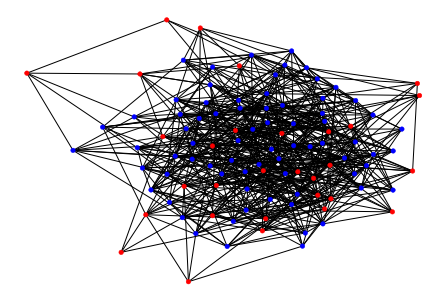

In [78]:
pos = nx.spring_layout(G)
nx.draw(G,pos,labels=features,node_size=20,node_color=color_map,with_labels=False)
plt.show()

In [79]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

G_dgl = dgl.from_networkx(G)
feat = X.drop(columns=['att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7'])

embedding = nn.Parameter(torch.tensor(feat.values,dtype=torch.float))

# embed = nn.Embedding(102, 5)  # 34 nodes with embedding dim equal to 5
G_dgl.ndata['feat'] =  embedding
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.6)
G_dgl.ndata['label'] = torch.tensor(features)

In [80]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [82]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [83]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [84]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [85]:
import time

#g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(G_dgl,
          in_dim=node_features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(200):
    if epoch >= 3:
        t0 = time.time()

    logits = net(node_features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], node_labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Epoch 00000 | Loss 10.9497 | Time(s) nan
Epoch 00001 | Loss 10.6985 | Time(s) nan
Epoch 00002 | Loss 10.4398 | Time(s) nan
Epoch 00003 | Loss 10.1731 | Time(s) 0.0582
Epoch 00004 | Loss 9.8985 | Time(s) 0.0587
Epoch 00005 | Loss 9.6183 | Time(s) 0.0527
Epoch 00006 | Loss 9.3352 | Time(s) 0.0489
Epoch 00007 | Loss 9.0460 | Time(s) 0.0464
Epoch 00008 | Loss 8.7527 | Time(s) 0.0462
Epoch 00009 | Loss 8.4640 | Time(s) 0.0457
Epoch 00010 | Loss 8.1856 | Time(s) 0.0448
Epoch 00011 | Loss 7.9129 | Time(s) 0.0440
Epoch 00012 | Loss 7.6467 | Time(s) 0.0433
Epoch 00013 | Loss 7.3873 | Time(s) 0.0431
Epoch 00014 | Loss 7.1356 | Time

In [86]:
from sklearn.metrics import accuracy_score, confusion_matrix
val_tens = torch.tensor(features)
_, indices_val = torch.max(logp[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logp[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7692307692307693
-------------------------------------------------------------
Classification Accuracy training set 0.6875
-------------------------------------------------------------
Confusion Matrix validation set:
[[ 4  8]
 [ 1 26]]
-------------------------------------------------------------
Confusion Matrix training set:
[[ 4 14]
 [ 6 40]]
